In [1]:
"""
Script to process all the LCDRI data, but stop the up profiles at ~8.75m

#Save one variable for the deeper only profiles, and another for the full profiles...
#How much does reducing minumum depth on up profiles impact SWH estimate?

"""


from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = []
big_spec_store_deep = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
big_uncertainty_store = []
big_loc_store = []
resid_store = np.array([])

#For investigating down profiles
#down_min_z = []
#up_min_z =[]


up = True

float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , 59))
    spec_store_deep = np.zeros((len(efr_files), 2, 59))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 2))
    loc_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #If up is true, flip everything
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
        else:
            #Do Nothing
            pass
            
        
        #Remove the beginning of the timesereis before the float starts moving
        #Need to do this for all of E1, E2, HX, HY, mlt_efr
        moving_inds = get_moving_inds(Pef)
        
        #Uncomment this to print out the filenames where EM starts before CTD
        #if len(moving_inds)<len(Pef):
            #print(len(Pef)-len(moving_inds), fname)
            #continue
            
        #Apply moving_inds to the EM timeseries
        E1 = E1[moving_inds]
        E2 = E2[moving_inds]
        HX = HX[moving_inds]
        HY = HY[moving_inds]
        mlt_efr = mlt_efr[moving_inds]
        Pef_moving = Pef[moving_inds]
        
        #Put in a filter to only keep stuff deeper than 8.7m.
######### Storing the deep ups
        if up:
            deepinds = np.where(Pef_moving>=15)
            E1_deep = E1[deepinds]
            E2_deep = E2[deepinds]
            HX_deep = HX[deepinds]
            HY_deep = HY[deepinds]
            mlt_efr_deep = mlt_efr[deepinds]
            Pef_moving_deep = Pef[deepinds]
            #Do the 50s fits 
            [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr_deep,nstep_off,navg_off,E1_deep,E2_deep,HX_deep,HY_deep);

            #Get overall fi and calculate the residuals
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                e1off=np.nanmean(e1offs,1);
                e2off=np.nanmean(e2offs,1);
                e1fit=np.nanmean(e1fits,1);
                e2fit=np.nanmean(e2fits,1);
                resid = np.nanmean(resid,1);

            #Calculate the residual
            e1r_deep = E1_deep - e1fit
            e2r_deep = E2_deep - e2fit

            ## Do spike detection
            #If either channel has spikes, ignore the profile.
            spikes=contains_spikes(E1_deep, E2_deep)
            if spikes:
                print(fname)
                continue
        
        
            #Now need to convert to velocity (m/s)
            e1r_deep = e1r_deep*sfv1
            e2r_deep = e2r_deep*sfv2


            #Now use the angles to rotate to x-y coordinates
            avg_angs = np.copy(anghxhy)
            avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                avg_angs = np.nanmean(avg_angs, axis=1)


            E2_r=e2r_deep*np.cos(avg_angs)+e1r_deep*np.sin(avg_angs);
            E1_r=-e2r_deep*np.sin(avg_angs)+e1r_deep*np.cos(avg_angs);

            E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
            E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)

            #Now try highpass filtering the data
            sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
            E_x_filtered = signal.sosfilt(sos, E_x)
            E_y_filtered = signal.sosfilt(sos, E_y)

            E_x = E_x_filtered
            E_y = E_y_filtered
            
            ##Get the mean residual level below 90m for the purpose of estimating error
            deep_inds = np.where(Pef_moving_deep>=90)
            error = np.sqrt(np.square(e1r_deep[deep_inds])+np.square(e2r_deep[deep_inds]))
            resid_store = np.append(resid_store, error)


            #Now take the spectra
            nblock = 120
            fs = 1
            overlap = 60

            #in the case where the float doesn't actually move for nblock measurements, need to skip it
            if len(E_x)<nblock:
                continue


            [u_x, z_x] = reshape_u(E_x, Pef_moving_deep, nblock, overlap, fs)
            [u_y, z_y] = reshape_u(E_y, Pef_moving_deep, nblock, overlap, fs)
            #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
            #for each spectral window
            #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
            [u_x_temp, t_new] = reshape_u(E_x, mlt_efr_deep, nblock, overlap, fs)

            prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

            prof_speed_new = np.zeros(len(prof_speed))
            for block_ind in range(z_x.shape[0]):
                prof_speed_try = np.abs(np.gradient(z_x[block_ind, :], t_new[block_ind, :]))
                z_inds = prof_speed_try<0.001
                prof_speed_try[z_inds]=np.nan
                prof_speed_removed_zeros = np.nanmean(prof_speed_try)
                prof_speed_new[block_ind]=prof_speed_removed_zeros

            prof_speed = prof_speed_new


            zero_inds = np.where(prof_speed==0)[0]
            #if len(zero_inds)>0:
                #print(z_x[0, :])

            UUwindow, fwindow = make_vel_spectrum(u_x, fs)

            VVwindow, fwindow = make_vel_spectrum(u_y, fs)

            min_z = np.min(Pef_moving_deep)

            if min_z>20:
                too_deep_counter+=1
            else:  
                min_bin = np.append(min_bin, min_z)
                first_bot = np.append(first_bot, z_x[0, -1])

                UU = UUwindow/(int(nblock/2)*fs)
                Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
                VV = VVwindow/(int(nblock/2)*fs)
                Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

                Eh = Exx+Eyy

                if np.isnan(np.nanmean(np.nanmean(Eh, axis=0))):
                    #print("All NaNs!!")
                    if nancounter==0:
                        #plt.loglog(fwindow, np.transpose(VVwindow))
                        #plt.plot(np.transpose(u_y))
                        #plt.loglog(fwindow[1:], np.transpose(Eh))
                        print(make_vel_spectrum(u_y, fs))

                    temp1 = np.expand_dims(np.array(E_x), axis=0)
                    temp2 = np.expand_dims(np.array(E_y), axis=0)
                    temp3 = np.append(temp1, temp2, axis=0)
                    nanstorer.append(temp3)
                    #if nancounter<10:
                    #    plt.figure()
                    #    plt.plot(E_x)
                    #    plt.plot(E_y)
                    nancounter+=1
                [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
                u_noise = 0 #This is just for testing...
                [lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
            
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    spec_store_deep[counter, 0, :] = np.nanmean(Eh, axis=0)
                    spec_store_deep[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)
        
#####  Back to regurlarly scheduled programming ####
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);
            resid = np.nanmean(resid,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit

        ## Do spike detection
        #If either channel has spikes, ignore the profile.
        spikes=contains_spikes(E1, E2)
        if spikes:
            print(fname)
            continue
        
        
        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

        E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
        E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
        
        
    
        ##Get the mean residual level below 90m for the purpose of estimating error
        deep_inds = np.where(Pef_moving>=90)
        error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
        resid_store = np.append(resid_store, error)
        
        
        #Now take the spectra
        nblock = 120
        fs = 1
        overlap = 60
        
        #in the case where the float doesn't actually move for nblock measurements, need to skip it
        if len(E_x)<nblock:
            continue
        
      
        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
        [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
        
        prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])

        prof_speed_new = np.zeros(len(prof_speed))
        for block_ind in range(z_x.shape[0]):
            prof_speed_try = np.abs(np.gradient(z_x[block_ind, :], t_new[block_ind, :]))
            z_inds = prof_speed_try<0.001
            prof_speed_try[z_inds]=np.nan
            prof_speed_removed_zeros = np.nanmean(prof_speed_try)
            prof_speed_new[block_ind]=prof_speed_removed_zeros

        prof_speed = prof_speed_new
        
        
        zero_inds = np.where(prof_speed==0)[0]
        #if len(zero_inds)>0:
            #print(z_x[0, :])
            
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y, fs)

        min_z = np.min(Pef)
            
        if min_z>20:
            too_deep_counter+=1
        else:  
            min_bin = np.append(min_bin, min_z)
            first_bot = np.append(first_bot, z_x[0, -1])

            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = VVwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

            Eh = Exx+Eyy
            
            if np.isnan(np.nanmean(np.nanmean(Eh, axis=0))):
                #print("All NaNs!!")
                if nancounter==0:
                    #plt.loglog(fwindow, np.transpose(VVwindow))
                    #plt.plot(np.transpose(u_y))
                    #plt.loglog(fwindow[1:], np.transpose(Eh))
                    print(make_vel_spectrum(u_y, fs))
                    
                temp1 = np.expand_dims(np.array(E_x), axis=0)
                temp2 = np.expand_dims(np.array(E_y), axis=0)
                temp3 = np.append(temp1, temp2, axis=0)
                nanstorer.append(temp3)
                #if nancounter<10:
                #    plt.figure()
                #    plt.plot(E_x)
                #    plt.plot(E_y)
                nancounter+=1
            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
            u_noise = 0 #This is just for testing...
            [lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)
            
            #Average each profile spec and add to the storer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
                spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)
                
                time_store[counter] = np.nanmean(mlt_efr)
                prof_store[counter] = float_id+"_"+str(prof_num)
                
                uncertainty_store[counter, :] = np.array([lbound, ubound])
                loc_store[counter, :] = np.array([avg_lat, avg_lon])
                if prof_num%2==0:
                    #Then it's even and its an up profile
                    up_down_store[counter] = 1
                else:
                    up_down_store[counter] = 0
                    spec_store_deep[counter, 0, :] = np.nanmean(Eh, axis=0)
                    spec_store_deep[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)

        
        
            counter+=1
        
        
    
    # Now store each one in a big array for sorting etc later
    if float_id_counter==0:
        big_spec_store=spec_store
        big_spec_store_deep = spec_store_deep
        big_uncertainty_store = uncertainty_store
        big_time_store = time_store
        big_up_down_store = up_down_store
        big_prof_store = prof_store
        big_loc_store = loc_store
    else:
        big_spec_store = np.append(big_spec_store, spec_store, axis=0)
        big_uncertainty_store = np.append(big_uncertainty_store,uncertainty_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)
        big_prof_store = np.append(big_prof_store, prof_store)
        big_loc_store = np.append(big_loc_store, loc_store, axis=0)
        big_spec_store_deep = np.append(big_spec_store_deep, spec_store_deep, axis=0)


    
    float_id_counter+=1
        
    #np.save(save_dir+float_id, spec_store)



/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:443: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:443: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:443: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)


/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0062-efr.mat


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:443: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:443: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:303: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:443: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:443: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59745/2163056064.py:443: RuntimeWarning: Mean of empty slice


In [3]:
"""
Script to process all the LCDRI data, but stop the up profiles at ~8.75m

#Save one variable for the deeper only profiles, and another for the full profiles...
#How much does reducing minumum depth on up profiles impact SWH estimate?

"""


from scipy.io import loadmat, savemat
from scipy import signal
from scipy.io import netcdf
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

#Degree of polynomial fit
Nfit=1

nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60
navg = 120 
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)

#Initialize arrays for storing stuff
big_spec_store = np.array([])
big_spec_store_deep = np.array([])
big_time_store = np.array([])
big_up_down_store = np.array([])
big_prof_store = np.array([])
big_uncertainty_store = np.array([])
big_loc_store = np.array([])
resid_store = np.array([])

#For investigating down profiles
#down_min_z = []
#up_min_z =[]


up = True
counter = 0
float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
first_bot = []

##Testing for nans -- TO DO: Think we can delete this nan stuff
nancounter = 0
nanstorer = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
    if ".DS_" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2 , 59))
    spec_store_deep = np.zeros((len(efr_files), 2, 59))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    uncertainty_store = np.zeros((len(efr_files), 2))
    loc_store = np.zeros((len(efr_files), 2))
    prof_store = np.empty(len(efr_files), dtype=object)
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            up = True
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            up = False
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

        #get conversion factor for converting to velocity
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        
        #Only want to look at down profiles here:
        if not up:
            continue
        if up:
            E1 = np.flip(E1)
            E2 = np.flip(E2)
            HZ = np.flip(HZ)
            HX = np.flip(HX)
            HY = np.flip(HY)
            Pef = np.flip(Pef)
            mlt_efr = np.flip(mlt_efr)
        
            #Remove the beginning of the timesereis before the float starts moving
            #Need to do this for all of E1, E2, HX, HY, mlt_efr
            moving_inds = get_moving_inds(Pef)
      
            
            #Apply moving_inds to the EM timeseries
            E1 = E1[moving_inds]
            E2 = E2[moving_inds]
            HX = HX[moving_inds]
            HY = HY[moving_inds]
            mlt_efr = mlt_efr[moving_inds]
            Pef_moving = Pef[moving_inds]
            
            #Do it for the deep ones only
            deepinds = np.where(Pef_moving>=15)
            E1_deep = E1[deepinds]
            E2_deep = E2[deepinds]
            HX_deep = HX[deepinds]
            HY_deep = HY[deepinds]
            mlt_efr_deep = mlt_efr[deepinds]
            Pef_moving_deep = Pef[deepinds]
            
            
            #Do the 50s fits 
            [e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);
            [e1offs_d,e2offs_d,e1fits_d,e2fits_d,anghxhy_d, resid] = em_offset(Nfit,mlt_efr_deep,nstep_off,navg_off,E1_deep,E2_deep,HX_deep,HY_deep)


            #Get overall fi and calculate the residuals
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                e1fit=np.nanmean(e1fits,1);
                e2fit=np.nanmean(e2fits,1);
                e1fit_d=np.nanmean(e1fits_d,1);
                e2fit_d=np.nanmean(e2fits_d,1);
            #Calculate the residual
            e1r = E1 - e1fit
            e2r = E2 - e2fit
            
            e1r_d = E1_deep - e1fit_d
            e2r_d = E2_deep - e2fit_d

            ## Do spike detection
            #If either channel has spikes, ignore the profile.
            spikes=contains_spikes(E1, E2)
            if spikes:
                print(fname)
                continue

            #Now need to convert to velocity (m/s)
            e1r = e1r*sfv1
            e2r = e2r*sfv2
            
            e1r_d = e1r_d*sfv1
            e2r_d = e2r_d*sfv1

            #Now use the angles to rotate to x-y coordinates
            avg_angs = np.copy(anghxhy)
            avg_angs_d = np.copy(anghxhy_d)
            avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
            avg_angs_d[~np.isnan(avg_angs_d)] = np.unwrap(avg_angs_d[~np.isnan(avg_angs_d)])


            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                avg_angs = np.nanmean(avg_angs, axis=1)
                avg_angs_d = np.nanmean(avg_angs_d, axis=1)


            E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs)
            E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs)
            
            E2_r_d=e2r_d*np.cos(avg_angs_d)+e1r_d*np.sin(avg_angs_d)
            E1_r_d=-e2r_d*np.sin(avg_angs_d)+e1r_d*np.cos(avg_angs_d)

            E_x = E1_r*np.cos(alpha1)-E2_r*np.sin(alpha1)
            E_y = E1_r*np.sin(alpha1)+E2_r*np.cos(alpha1)
            E_x_d = E1_r_d*np.cos(alpha1)-E2_r_d*np.sin(alpha1)
            E_y_d = E1_r_d*np.sin(alpha1)+E2_r_d*np.cos(alpha1)

            #Now try highpass filtering the data
            sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
            E_x_filtered = signal.sosfilt(sos, E_x)
            E_y_filtered = signal.sosfilt(sos, E_y)
            E_x_filtered_d = signal.sosfilt(sos, E_x_d)
            E_y_filtered_d = signal.sosfilt(sos, E_y_d)
            

            E_x = E_x_filtered
            E_y = E_y_filtered
            E_x_d = E_x_filtered_d
            E_y_d = E_y_filtered_d

            #Now take the spectra
            nblock = 120
            fs = 1
            overlap = 60

            #in the case where the float doesn't actually move for nblock measurements, need to skip it
            if len(E_x)<nblock:
                continue


            [u_x, z_x] = reshape_u(E_x, Pef_moving, nblock, overlap, fs)
            [u_y, z_y] = reshape_u(E_y, Pef_moving, nblock, overlap, fs)
            #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
            #for each spectral window
            #Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
            [u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)
            
            ###HI JAMES LEFT OFF HERE!!##
            [u_x_d, z_x_d] = reshape_u(E_x_d, Pef_moving_deep, nblock, overlap, fs)
            [u_y_d, z_y_d] = reshape_u(E_y_d, Pef_moving_deep, nblock, overlap, fs)
            [u_x_temp_d, t_new_d] = reshape_u(E_x_d, mlt_efr_deep, nblock, overlap, fs)

            prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])
            prof_speed_d = np.abs(z_x_d[:, 0]-z_x_d[:, -1])/np.abs(t_new_d[:, 0]-t_new_d[:, -1])
            
            prof_speed_new = np.zeros(len(prof_speed))            
            prof_speed_new_d = np.zeros(len(prof_speed_d))
            
            for block_ind in range(z_x.shape[0]):
                prof_speed_try = np.abs(np.gradient(z_x[block_ind, :], t_new[block_ind, :]))
                z_inds = prof_speed_try<0.001
                prof_speed_try[z_inds]=np.nan
                prof_speed_removed_zeros = np.nanmean(prof_speed_try)
                prof_speed_new[block_ind]=prof_speed_removed_zeros

            prof_speed = prof_speed_new

            for block_ind in range(z_x_d.shape[0]):
                prof_speed_try = np.abs(np.gradient(z_x_d[block_ind, :], t_new_d[block_ind, :]))
                z_inds = prof_speed_try<0.001
                prof_speed_try[z_inds]=np.nan
                prof_speed_removed_zeros = np.nanmean(prof_speed_try)
                prof_speed_new_d[block_ind]=prof_speed_removed_zeros

            prof_speed_d = prof_speed_new_d
            

            zero_inds = np.where(prof_speed==0)[0]
            #if len(zero_inds)>0:
                #print(z_x[0, :])

            UUwindow, fwindow = make_vel_spectrum(u_x, fs)
            VVwindow, fwindow = make_vel_spectrum(u_y, fs)
            
            UUwindow_d, fwindow = make_vel_spectrum(u_x_d, fs)
            VVwindow_d, fwindow = make_vel_spectrum(u_y_d, fs)

            min_z = np.min(Pef)

            if min_z>20:
                too_deep_counter+=1
            else:  
                min_bin = np.append(min_bin, min_z)
                first_bot = np.append(first_bot, z_x[0, -1])

                UU = UUwindow/(int(nblock/2)*fs)
                Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
                VV = VVwindow/(int(nblock/2)*fs)
                Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

                Eh = Exx+Eyy
                
                UU_d = UUwindow_d/(int(nblock/2)*fs)
                Exx_d = UU_d[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
                VV_d = VVwindow_d/(int(nblock/2)*fs)
                Eyy_d = VV_d[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

                Eh_d = Exx_d+Eyy_d
    
                [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)
                [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4_d] = depth_correct_Eric(Eh_d, fwindow[1:], z_x_d, prof_speed_d, nblock, Cmax, fs)


                #u_noise = 0 #This is just for testing...
                #[lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)

                #Average each profile spec and add to the storer
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    if counter == 0:
                        big_spec_store = np.expand_dims(np.nanmean(Eh_Eric4, axis=0), axis=0)
                        big_spec_store_deep = np.expand_dims(np.nanmean(Eh_Eric4_d, axis=0), axis=0)
                    else:
                        big_spec_store = np.append(big_spec_store, np.expand_dims(np.nanmean(Eh_Eric4, axis=0), axis=0), axis=0)
                        big_spec_store_deep = np.append(big_spec_store_deep, np.expand_dims(np.nanmean(Eh_Eric4_d, axis=0), axis=0), axis=0)
                    big_time_store = np.append(time_store, np.nanmean(mlt_efr))
                    big_prof_store = np.append(prof_store, float_id+"_"+str(prof_num))

                    #uncertainty_store[counter, :] = np.array([lbound, ubound])
                 
                counter+=1

        
        
        

/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0062-efr.mat


/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59229/1771670650.py:316: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_59229/1771670650.py:325: RuntimeWarning: Mean of empty slice
  prof_speed_removed_zeros = np.nanmean(prof_speed_try)


In [31]:
#Try adding tails and then calc'ing swh
spec_store= add_hf_tail(big_spec_store, fwindow[1:])
spec_store_deep = add_hf_tail(big_spec_store_deep, fwindow[1:])

[Hs, lower, upper] = sig_wave_height(fwindow, np.transpose(spec_store))
[Hs_deep, lower_deep, upper_deep] = sig_wave_height(fwindow, np.transpose(spec_store_deep))



IndexError: index 0 is out of bounds for axis 0 with size 0

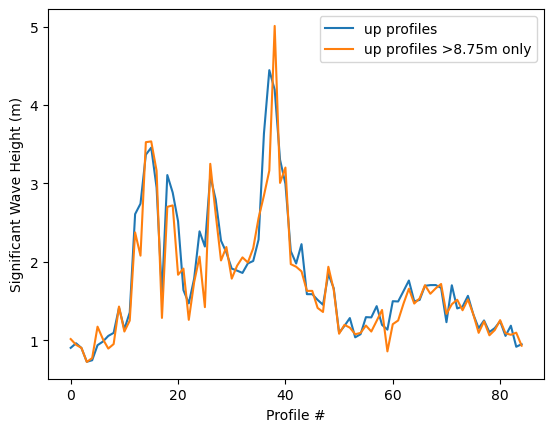

In [28]:
plt.plot(Hs_corr[ups], label='up profiles')
plt.plot(Hs_corr_deep[ups], label="up profiles >8.75m only")
plt.xlabel("Profile #")
plt.ylabel("Significant Wave Height (m)")
plt.legend()

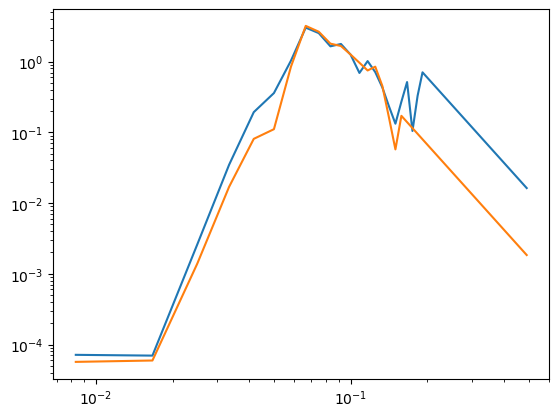

In [7]:
ind = 50
plt.loglog(fwindow[1:], spec_store[ind, :])
plt.loglog(fwindow[1:], spec_store_deep[ind, :])


###OK so takeaway is that stopping the ups early primarily just shifts the max frequency, and doesn't really change amplitude of low frequency waves
### So systematic bias likely more due to rotation frequency?

In [2]:
#Cell for sorting the arrays by time


#Getting rid of the profiles where minimum depth was below 20m
kill = np.where(big_spec_store[:, 0, 5]==0)


spec_store_shallow = np.delete(big_spec_store, kill[0], axis=0)
spec_store_deep = np.delete(big_spec_store_deep, kill[0], axis=0)
time_store_shallow = np.delete(big_time_store, kill[0], axis=0)
up_down_store_shallow = np.delete(big_up_down_store, kill[0], axis=0)
prof_store_shallow = np.delete(big_prof_store, kill[0], axis=0)
uncertainty_store_shallow = np.delete(big_uncertainty_store, kill[0], axis=0)

out = zip(spec_store_shallow, up_down_store_shallow, time_store_shallow, prof_store_shallow)
out2 = zip(uncertainty_store_shallow, time_store_shallow, spec_store_deep)
#list(out)[0]
sorted_array = sorted(out, key=lambda tup: tup[2])
sorted_array2 = sorted(out2, key=lambda tup: tup[1])

unzipped = ([ a for a,b,c,d in sorted_array ], [ b for a,b,c,d in sorted_array ], [c for a,b,c,d in sorted_array], [d for a,b,c,d in sorted_array])
unzipped2 = ([ a for a,b,c in sorted_array2 ], [ b for a,b,c in sorted_array2 ], [c for a,b,c in sorted_array2 ])

spec_store_sorted = np.array(unzipped[0])
up_down_store_sorted = np.array(unzipped[1])
time_store_sorted = np.array(unzipped[2])
prof_store_sorted = np.array(unzipped[3])

uncertainty_store_sorted = np.array(unzipped2[0])
spec_store_deep_sorted = np.array(unzipped2[2])



#For the deep stuff, set all the down profiles to nans
#up_down_store_shallow



In [11]:
big_spec_store.shape

(85, 59)

16.044578167866764


Text(0.5, 1.0, 'EM-APEX (down) vs. CDIP signficant wave heights ')

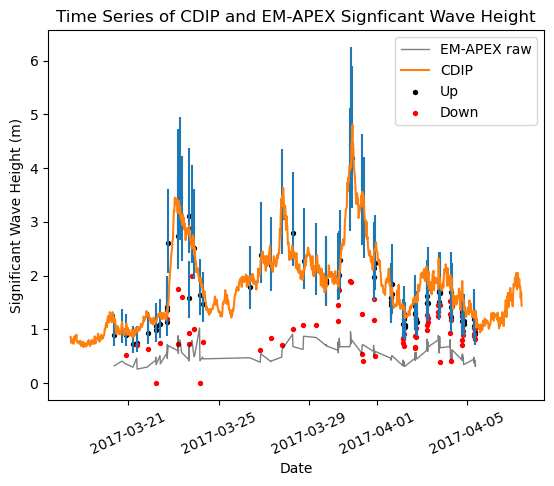

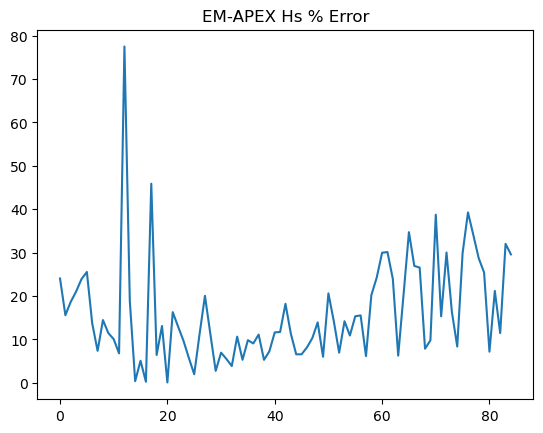

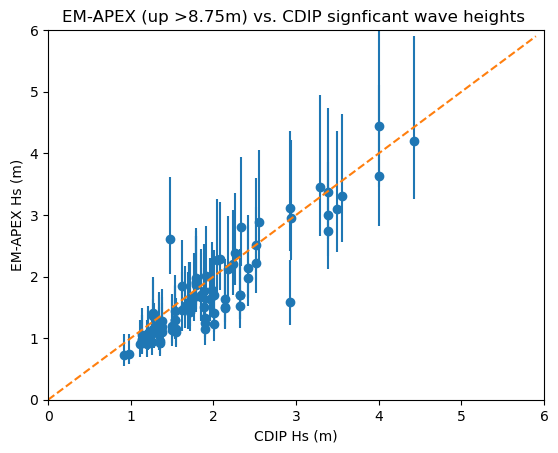

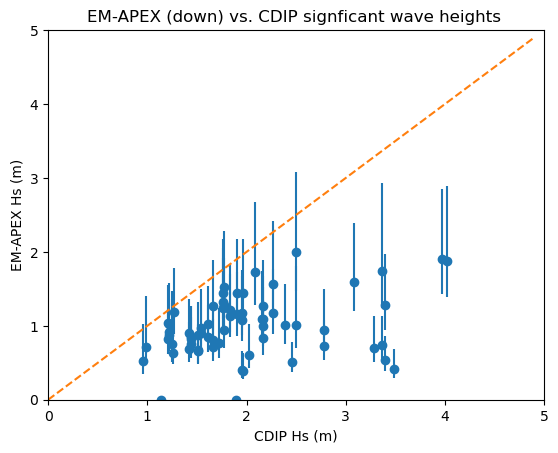

In [3]:
#Cell for plotting time series of significant wave heights and scatter plots of cdip vs. EM-APEX

spec_store_sorted_new_raw = spec_store_sorted[:, 0, :]
spec_store_sorted_new_corr = spec_store_sorted[:, 1, :]

spec_store_deep_sorted_new = spec_store_deep_sorted[:, 1, :]

spec_store_sorted_new_corr = add_hf_tail(spec_store_sorted_new_corr, fwindow[1:])
spec_store_deep_sorted_new = add_hf_tail(spec_store_deep_sorted_new, fwindow[1:])
sig_wave_array = [];

[Hs,lower,upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_raw))
[Hs_corr, lower, upper] = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr), uncertainty_store_sorted)
[Hs_corr_deep, lower_deep, upper_deep] = sig_wave_height(fwindow, np.transpose(spec_store_deep_sorted_new), uncertainty_store_sorted)



errors = np.zeros((2, len(lower)))
errors[0,:]=lower
errors[1,:]=upper

t_apex = np.array([datetime.datetime.fromtimestamp(t) for t in time_store_sorted])

ups = np.where(up_down_store_sorted==1)[0]
downs = np.where(up_down_store_sorted==0)[0]

plt.plot(t_apex, Hs, color='k', linewidth=1, alpha=0.5, label='EM-APEX raw')
plt.scatter(t_apex[ups], Hs_corr[ups], color='k', s=8, label='Up')
plt.scatter(t_apex[downs], Hs_corr[downs], color='r', s=8, label='Down')
plt.errorbar(t_apex[ups], Hs_corr[ups], yerr = errors[:, ups], fmt='none')
#plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')


fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = [datetime.datetime.fromtimestamp(t) for t in times]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
cdip_lat = np.nanmean(nc.variables['gpsLatitude'][:])
cdip_lon = np.nanmean(nc.variables['gpsLongitude'][:])

#dtimes = datetime(time, 'convertfrom', 'posixtime');
nc.close()
plt.plot(ts, Hs_cdip, label='CDIP')
plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Signficant Wave Height")
plt.legend()

#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/CDIP_EM_Hs_Timeseries.png", bbox_inches='tight')


##Get Errors
#first need to match up teh 
cdip_inds = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted[ups])):
    ind2 = np.where(np.abs(time_store_sorted[ups][ind]-times)==np.min(np.abs(time_store_sorted[ups][ind]-times)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds = np.append(cdip_inds, ind2[0])
    
errs = Hs_corr[ups] - Hs_cdip[cdip_inds]

np.where(errs==np.max(errs))


#errs = np.delete(errs, np.where(errs==np.max(errs))[0])
plt.figure()
perc_errors = 100*(np.abs(Hs_corr[ups]-Hs_cdip[cdip_inds]))/Hs_cdip[cdip_inds]
plt.plot(perc_errors)
plt.title("EM-APEX Hs % Error")
print(np.nanmean(perc_errors))
plt.figure()
plt.scatter(Hs_cdip[cdip_inds], Hs_corr[ups])
plt.errorbar(Hs_cdip[cdip_inds], Hs_corr[ups], yerr = errors[:, ups], fmt='none')

y = np.arange(0, 6, 0.1)
plt.plot(np.arange(0, 6, 0.1), y, '--')
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.xlabel("CDIP Hs (m)")
plt.ylabel("EM-APEX Hs (m)")
plt.title("EM-APEX (up >8.75m) vs. CDIP signficant wave heights ")



cdip_inds_down = np.array([], dtype=int)
for ind in range(0, len(time_store_sorted[downs])):
    ind2 = np.where(np.abs(time_store_sorted[downs][ind]-times)==np.min(np.abs(time_store_sorted[downs][ind]-times)))
    #plt.loglog(wave_freq, energy_density[ind2[0][0], :], label="CDIP")
    cdip_inds_down = np.append(cdip_inds_down, ind2[0])
    

plt.figure()
plt.scatter(Hs_cdip[cdip_inds_down], Hs_corr[downs])
plt.errorbar(Hs_cdip[cdip_inds_down], Hs_corr[downs], yerr = errors[:, downs], fmt='none')


y = np.arange(0, 5, 0.1)
plt.plot(np.arange(0, 5, 0.1), y, '--')
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.xlabel("CDIP Hs (m)")
plt.ylabel("EM-APEX Hs (m)")
plt.title("EM-APEX (down) vs. CDIP signficant wave heights ")

Text(0.5, 1.0, 'EM-APEX vs. CDIP wave heights for up profiles and up \n profiles ignoring measurements shallower than 8.75m')

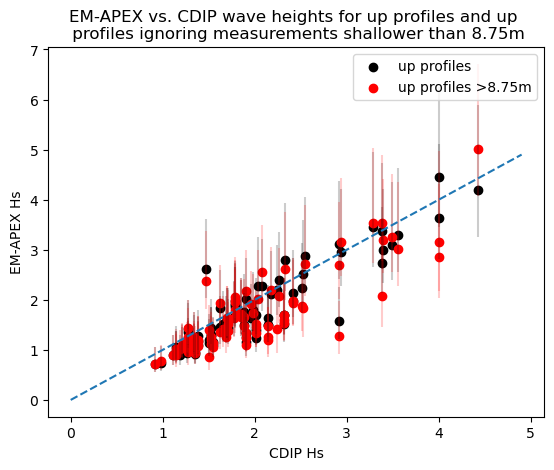

In [12]:
plt.figure()
plt.scatter(Hs_cdip[cdip_inds], Hs_corr[ups], color='k', label="up profiles")
plt.errorbar(Hs_cdip[cdip_inds], Hs_corr[ups], yerr = errors[:, ups], color='k', alpha=0.2, fmt='none')
plt.scatter(Hs_cdip[cdip_inds], Hs_corr_deep[ups], color='red', label='up profiles >8.75m')
plt.errorbar(Hs_cdip[cdip_inds], Hs_corr_deep[ups], yerr = errors[:, ups], color='r', alpha=0.2, fmt='none')
y = np.arange(0, 5, 0.1)
plt.plot(np.arange(0, 5, 0.1), y, '--')
plt.legend()
plt.xlabel("CDIP Hs")
plt.ylabel("EM-APEX Hs")
plt.title("EM-APEX vs. CDIP wave heights for up profiles and up \n profiles ignoring measurements shallower than 8.75m")

In [19]:
down_inds = up_down_store_shallow==0
spec_store_deep_sorted_new[down_inds].shape

(67, 59)

In [17]:
spec_store_deep_sorted_new.shape

(152, 59)

In [18]:
spec_store_sorted_new_corr

(152, 59)

In [93]:
import scipy
nu = 11*36/19*100

cl = nu/scipy.stats.chi2.ppf(1-.05/2, df=nu)
cu = nu/scipy.stats.chi2.ppf(.05/2, df=nu)


#cl = nu/(chi_sq*(1-.05/2))
#cu =nu/(chi_sq*(.05/2))

In [94]:
cl

0.941958235625599

In [95]:
cu

1.0636041110393386

In [78]:
nb=11
DOF = 36*np.square(nb)/(19*nb - 1)
phi_inv = -1.96
phi_inv_m1 = 1.96
#At 95% CI
Qvp = DOF*( ( 1-(2/(DOF*9))+phi_inv*(((2/(DOF*9))**(1/2))))**3 )
Qvp_m1 = DOF*( ( 1-(2/(DOF*9))+phi_inv_m1*(((2/(DOF*9))**(1/2))))**3 )

lbound = DOF/Qvp_m1
ubound = DOF/Qvp

In [79]:
lbound

0.5914910236433912

In [80]:
ubound

2.047706571811529

In [81]:
1/cl

1.5190515362389794